In [53]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import math
import numpy as np
import ast
from tqdm import tqdm
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score

In [54]:
transactions = pd.read_csv("transactions.csv")

# Convert the string date to datetime format and calculate the "day" of the purchase.
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])
transactions["day"] = (transactions["purchase_date"] - datetime(2020, 6, 1)).apply(lambda x: x.days)
transactions

,customer_id,product_id,purchase_date,quantity,day
0,38769,3477,2020-06-01,1,0
1,42535,30474,2020-06-01,1,0
2,42535,15833,2020-06-01,1,0
3,42535,20131,2020-06-01,1,0
4,42535,4325,2020-06-01,1,0
...,...,...,...,...,...
1071533,22114,29567,2021-01-31,2,244
1071534,22114,21068,2021-01-31,1,244
1071535,10900,18270,2021-01-31,1,244
1071536,17894,31265,2021-01-31,5,244


In [55]:
products = pd.read_csv("product_catalog.csv")
products.sort_values(by="product_id",inplace=True)
products.reset_index(drop=True,inplace=True)
products

,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories
0,0,389,4,2,469,0,-1,NaN
1,1,1006,4,0,487,3,66,"[2459, 274, 4124]"
2,2,464,4,1,484,0,66,NaN
3,3,389,8,1,529,0,39,"[807, 3403]"
4,4,1291,4,0,457,0,-1,"[281, 1114, 3800]"
...,...,...,...,...,...,...,...,...
32771,32771,995,10,0,515,3,188,NaN
32772,32772,333,6,1,503,0,17,"[2005, 1000, 3941]"
32773,32773,284,4,1,531,0,148,"[1705, 385, 2256, 2722, 248, 346, 3042]"
32774,32774,433,4,0,455,0,-1,[3254]


The ranges of the attributes vary. Attribute 3 has 539 (excluding -1) values whereas attribute 2 has only 4 values.

In [56]:
attributes_df = products[['attribute_1','attribute_2' , 'attribute_3', 'attribute_4', 'attribute_5']]
column_ranges = attributes_df.apply(lambda col: (col.min(), col.max()))
column_ranges

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5
0,-1,0,-1,-1,-1
1,10,3,538,4,190


All attributes have the "-1" value except attribute 2. "-1" attribute value is a problem in data. We filled up "-1" values according to mode attribute value of products with the same attribute 2 since it is the most complete one we have.

In [57]:
attribute_columns = ['attribute_1', 'attribute_3', 'attribute_4', 'attribute_5']
modes = products.groupby(by="attribute_2")[attribute_columns].apply(lambda x: x[x != -1].mode().iloc[0])
for col in attribute_columns:
    products[col] = products.apply(lambda row: int(modes.loc[row['attribute_2']][col]) if row[col] == -1 else int(row[col]),axis=1)

products

,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories
0,0,389,4,2,469,0,66,NaN
1,1,1006,4,0,487,3,66,"[2459, 274, 4124]"
2,2,464,4,1,484,0,66,NaN
3,3,389,8,1,529,0,39,"[807, 3403]"
4,4,1291,4,0,457,0,17,"[281, 1114, 3800]"
...,...,...,...,...,...,...,...,...
32771,32771,995,10,0,515,3,188,NaN
32772,32772,333,6,1,503,0,17,"[2005, 1000, 3941]"
32773,32773,284,4,1,531,0,148,"[1705, 385, 2256, 2722, 248, 346, 3042]"
32774,32774,433,4,0,455,0,17,[3254]


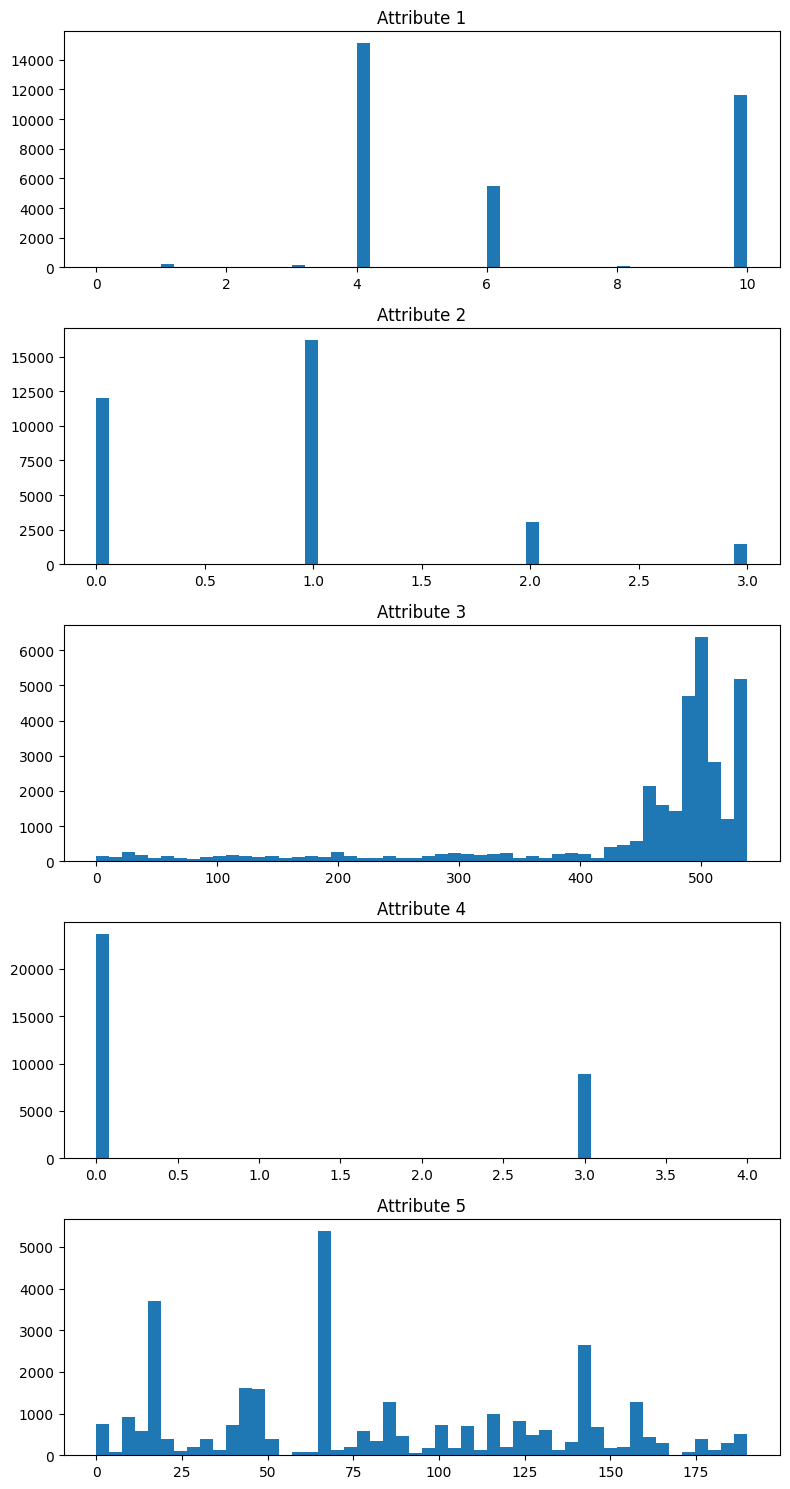

In [58]:
fig, ax = plt.subplots(5, 1, figsize=(8, 15))
for i in range(5):
    ax[i].hist(products[f"attribute_{i+1}"], bins=50)
    ax[i].set_title(f"Attribute {i+1}")
fig.tight_layout()

In [59]:
product_categories = pd.read_csv("product_category_map.csv")
duplicate_categories = product_categories[product_categories.duplicated(subset="category_id", keep=False)]
display(duplicate_categories)
print("Number of duplicate categories is", duplicate_categories["category_id"].nunique())


,category_id,parent_category_id
207,207,2917
208,207,3685
264,263,772
265,263,1666
331,329,2917
...,...,...
3662,3632,1666
3839,3809,3829
3840,3809,3001
3922,3891,1062


Number of duplicate categories is 31


There are 31 categories in the data that are duplicated with different parent categories. We believed this might be a problem, but it likely wouldn't significantly impact the overall results. Therefore, we decided to remove the duplicates and retain just one version of each category.

In [60]:
product_categories = product_categories.drop_duplicates("category_id").reset_index(drop=True)


We checked each category-parent chain to understand the tree structure of the categories. We observed that there are no cycles and all category chains end up at category 3898, the root category

In [61]:
hierarchy_chains = []
for cat in product_categories["category_id"]:
    lst = []
    while True:
        lst.append(cat)
        cat = product_categories.loc[product_categories["category_id"]== cat,"parent_category_id"].values[0]
        if cat in lst:
            hierarchy_chains.append(lst)
            break
display(hierarchy_chains)

different_root_count = 0
for chain in hierarchy_chains:
    if chain[-1] != 3898:
        different_root_count+=1


print("There exists",  different_root_count, "chains that doesn't end up at 3898")

[[0, 75, 2364, 3898],
 [1, 1499, 3761, 2723, 3898],
 [2, 1082, 2231, 3898],
 [3, 3498, 2364, 3898],
 [4, 1623, 1825, 3898],
 [5, 2478, 2364, 3898],
 [6, 1582, 2364, 3898],
 [7, 3027, 1840, 3898],
 [8, 2364, 3898],
 [9, 3590, 3178, 2346, 3898],
 [10, 582, 34, 3898],
 [11, 3686, 1049, 2346, 3898],
 [12, 3241, 600, 3898],
 [13, 510, 2231, 3898],
 [14, 2160, 678, 3898],
 [15, 1765, 432, 3898],
 [16, 3786, 2284, 2392, 1072, 3898],
 [17, 844, 1111, 772, 252, 3898],
 [18, 1640, 2364, 3898],
 [19, 3772, 484, 875, 3898],
 [20, 2741, 2497, 2793, 3898],
 [21, 802, 678, 3898],
 [22, 2246, 3174, 432, 3898],
 [23, 3830, 982, 275, 3898],
 [24, 3550, 1072, 3898],
 [25, 1125, 2401, 1272, 181, 2087, 3624, 3898],
 [26, 1790, 3898],
 [27, 1987, 3178, 2346, 3898],
 [28, 2516, 2723, 3898],
 [29, 3488, 2364, 3898],
 [30, 1682, 3898],
 [31, 3643, 2086, 2793, 3898],
 [32, 138, 3572, 3616, 3898],
 [33, 2364, 3898],
 [34, 3898],
 [35, 3159, 3541, 3504, 3898],
 [36, 678, 3898],
 [37, 2114, 2266, 1559, 3898],
 [38

There exists 0 chains that doesn't end up at 3898


We filled the null categories with the root category (3898) because dealing with null values would be problematic for the later stages of the project.

In [62]:
products["categories"] = products["categories"].fillna("[3898]")
products["categories"] = products["categories"].apply(ast.literal_eval)


There are 4300 categories in total. Only 484 of them are the children of the root in the category tree. We changed each category with its second-most parent to reduce the number of unique categories.

In [63]:
print("Number of categories in second highest parent order:", len(product_categories[product_categories["parent_category_id"]==3898]))

Number of categories in second highest parent order: 484


In [64]:
#Set each product's categories to its second highest parent categories to reduce the number of unique categories
for i in range(len(products)):
    for j in range(len(products.loc[i, "categories"])):
        cat = products.loc[i, "categories"][j]
        if len(hierarchy_chains[cat]) > 1:
            products.loc[i,"categories"][j] = hierarchy_chains[cat][-2]
        
    cat_lst = products.loc[i, "categories"]
    products.at[i, "categories"] = list(set(cat_lst))


products

,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories
0,0,389,4,2,469,0,66,[3898]
1,1,1006,4,0,487,3,66,"[1840, 2920, 4124]"
2,2,464,4,1,484,0,66,[3898]
3,3,389,8,1,529,0,39,[2346]
4,4,1291,4,0,457,0,17,"[3616, 2006]"
...,...,...,...,...,...,...,...,...
32771,32771,995,10,0,515,3,188,[3898]
32772,32772,333,6,1,503,0,17,"[3056, 3941, 1559]"
32773,32773,284,4,1,531,0,148,"[370, 2346, 686]"
32774,32774,433,4,0,455,0,17,[366]


Plot of the number of products belonging to each category, excluding 3898 (the root category).

<BarContainer object of 452 artists>

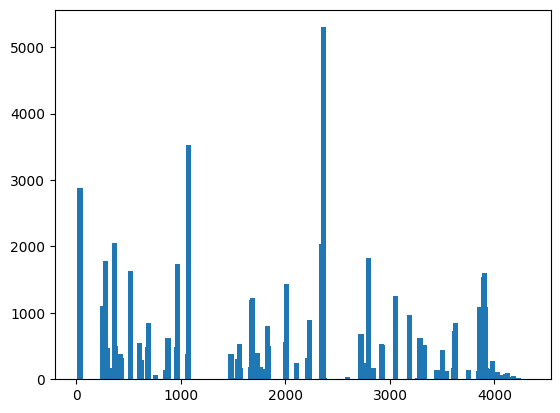

In [65]:
category_counts = {}

for idx, row in products.iterrows():
    for cat in row["categories"]:
        if cat==3898:
            continue
        if cat in category_counts:
            category_counts[cat] += 1
        else:
            category_counts[cat] = 1

plt.bar(category_counts.keys(), category_counts.values(), width=50)

Since attribute 3 has the largest range, we suspected that products with the same attribute 3 would be more similar.

In [66]:
#Two examples showing how products with the same attribute 3 values also has mostly same other attributes and common categories
display(products[products["attribute_3"] == 7])
display(products[products["attribute_3"] == 24])

,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories
4533,4533,703,10,0,7,0,84,"[1480, 2793, 252, 519]"
6162,6162,703,10,3,7,0,84,"[1480, 2793, 252, 519]"


,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories
1449,1449,968,10,0,24,0,87,"[4089, 3915, 2012]"
24754,24754,968,10,0,24,0,87,"[4089, 2012]"
